In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sklm
import warnings 
warnings.filterwarnings("ignore") # Ignore annoying warnings
# from sklearn.model_selection import cross_val_score

dataDir = './Data/'
mungedFileName = dataDir + 'mungedData.pkl'

cdf = pd.read_pickle(mungedFileName)

In [2]:
# y is True if any readmission variable is hot. It's NaN if all variables are null.
y = cdf[['READMISSION1-Yes','READMISSION-Yes']].any(1)
y[cdf[['READMISSION1-Yes','READMISSION-Yes']].isnull().all(1)] = np.nan

# Would like to drop rows with NaN y data
nanIdx = np.isnan(y).nonzero()
y = np.delete(y.ravel(), nanIdx ,axis=0)
cdf.drop(cdf.index[nanIdx], axis=0, inplace=True)

# Either drop or keep columns from cdf
dropOrKeep = True
if dropOrKeep:
    dropList = ['READMISSION-','READMISSION1-','REOPERATION-',\
                'REOPERATION1-','NWNDINFD-','WNDINFD-','DEHIS-','NDEHIS-',\
                'MORBPROB','NSUPINFEC-','SUPINFEC-','RETORPODAYS','OTHSYSEP',\
                'NOTHSYSEP-']
    colsToDrop = [colName for colName in cdf.columns if np.any([dropItem in colName for dropItem in dropList])]
    cdf = cdf.drop(colsToDrop,1)
    print('Dropped some variables: ')
    print(colsToDrop)
    # These are being dropped automatically by Imputer
    colsToDrop = [ 4,5,6,16,17,18,137,191,192,193,194,195,212,213,214,236,237,238,\
                  239,284,285,316,317,350,351,411,412,413,414,505,506,507,514,517]
    cdf = cdf.drop(cdf.columns[colsToDrop],axis=1)
    
else:
    # Dropping these columns is super-cumbersome. Let's find a list to keep
    # Need to add FNSTATUS1 and RBC
    keepList = ['SEX', 'RACE_NEW','ETHNICITY_HISPANIC','AGE','ANESTHES','HEIGHT','WEIGHT','DIABETES',\
                'SMOKE','PACKS','ETOH','DYSPNEA','FNSTATUS2','VENTILAT','HXCOPD','CPNEUMON',\
                'HXCHF','HXMI','PRVPCI','PRVPCS','HXANGINA','HYPERMED','HXPVD','RENAFAIL','DIALYSIS',\
                'CVA','DISCANCR','WNDINF','STEROID','WTLOSS','BLEEDDIS','PROPER30','ASACLASS',\
                'ASCITES','PRSODM','PRBUN','PRCREAT','PRALBUM','PRBILI','PRSGOT','PRALKPH','PRWBC'\
                'PRHCT','PRPLATE','PRPTT','PRINR','PRPT','PGY']
    colsToKeep = [colName for colName in cdf.columns if np.any([keepItem in colName for keepItem in keepList])]
    cdf = cdf[colsToKeep]

Dropped some variables: 
['DEHIS-No Complication', 'DOTHSYSEP', 'MORBPROB', 'NDEHIS-0', 'NOTHSYSEP-0', 'NSUPINFEC-0', 'NWNDINFD-0', 'OTHSYSEP-No Complication', 'READMISSION-Yes', 'READMISSION1-Yes', 'REOPERATION-Yes', 'REOPERATION1-Yes', 'RETORPODAYS', 'SUPINFEC-No Complication', 'UNPLANNEDREADMISSION1-Yes', 'UNPLANREADMISSION-Yes', 'WNDINFD-Deep Incisional SSI']


In [3]:
# Impute missing data in cdf
colNames = cdf.columns
imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=True)
imp.fit(cdf)
X = imp.transform(cdf)
cdf = pd.DataFrame(X, columns=colNames)

# Scale the columns
X = StandardScaler().fit_transform(cdf)
cdf = pd.DataFrame(X, columns=colNames)

# Add an intercept
cdf['intercept'] = 1.0

In [4]:
# Split for cross-validation
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cdf, y, test_size=0.25, random_state=0)

In [5]:
C = .01 # Regularization strength, smaller is stronger
lr = LogisticRegression(C=C, penalty='l1', tol=0.01) # Use L1, for LASSO

In [6]:
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
# scores = cross_val_score(lr, cdf, y, cv=10,scoring='roc_auc')
# scores
tuned_parameters = [{'C': np.logspace(-3,0,20,base=10)}]
gscv = GridSearchCV(lr, tuned_parameters, cv=5,scoring='roc_auc',verbose=100)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=0.001 .........................................................
[CV] ................................ C=0.001, score=0.500000 -   0.3s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.3s
[CV] C=0.001 .........................................................
[CV] ................................ C=0.001, score=0.500000 -   0.2s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:    0.4s
[CV] C=0.001 .........................................................
[CV] ................................ C=0.001, score=0.500000 -   0.2s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:    0.6s
[CV] C=0.001 .........................................................
[CV] ................................ C=0.001, score=0.500000 -   0.2s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    0.8s
[CV] C=0.001 .........................................................
[CV] ................................ C=0.001, scor

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.01,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': array([ 0.001  ,  0.00144,  0.00207,  0.00298,  0.00428,  0.00616,
        0.00886,  0.01274,  0.01833,  0.02637,  0.03793,  0.05456,
        0.07848,  0.11288,  0.16238,  0.23357,  0.33598,  0.48329,
        0.69519,  1.     ])}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=100)

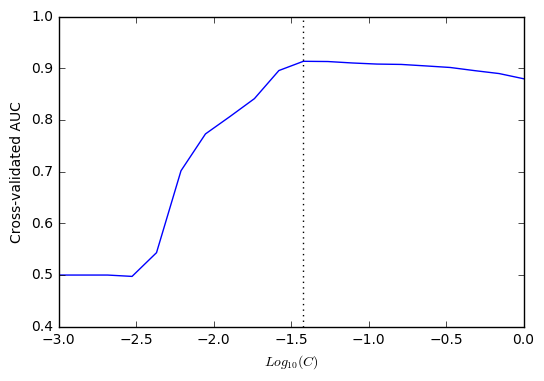

In [61]:
gscv.grid_scores_
means = [mean_score for params, mean_score, scores in gscv.grid_scores_]
Cs = [params['C'] for params, mean_score, scores in gscv.grid_scores_]
plt.plot(np.log10(Cs), means)
bestC = gscv.best_params_['C']
ylims = plt.gca().get_ylim()
plt.plot(np.log10([bestC, bestC]),ylims,color='k',ls=':')
plt.ylim(ylims)
plt.xlabel('$Log_{10}(C)$')
plt.ylabel('Cross-validated AUC')
plt.show()


In-sample ROC AUC = 0.938 
Test ROC AUC = 0.862 


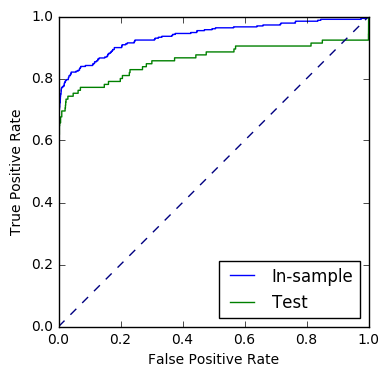

In [10]:
# Plot an ROC for training
plt.clf
pred_train = gscv.predict_proba(X_train)[:,1]
rocAUC_train = sklm.roc_auc_score(y_train,pred_train)
print('In-sample ROC AUC = %.3f ' % rocAUC_train)
fpr, tpr, _ = sklm.roc_curve(y_train, pred_train)
plt.figure()
plt.plot(fpr,tpr,label='In-sample')

pred_test = gscv.predict_proba(X_test)[:,1]
rocAUC_test = sklm.roc_auc_score(y_test,pred_test)
print('Test ROC AUC = %.3f ' % rocAUC_test)
fpr, tpr, _ = sklm.roc_curve(y_test, pred_test)
plt.plot(fpr,tpr,label='Test')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='lower right')
plt.show()

In [22]:
bestEst = gscv.best_estimator_
coeffs = bestEst.coef_[1]
coeffIdx = np.nonzero(coeffs != 0)
[cdf.columns[item] for item in coeffIdx]
for idx in coeffIdx:
    print(idx)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 41  43  44  53  55  59  65  97 127 130 134 138 141 142 147 154 156 165
 166 174 181 182 183 184 185 186 187 198 207 214 220 225 228 234 235 236
 237 238 241 242 246 247 248 257 258 259 260 261 263 346 347 349 356 361
 362 365 368 376 382 386 387 394 397 399 400 401 403 405 406 408 410 411
 419 425 426 430 434 435 436 438 439 442 451 453 455 460 466 468 471 474
 489 502 504 514 518]


In [58]:
coeffs = bestEst.coef_.ravel()
coeffIdx = np.nonzero(coeffs != 0)[0]

for idx in coeffIdx:
    print('Coeff: %.3f \t %s' % (coeffs[idx], cdf.columns[idx]))

Coeff: -0.089 	 ASACLAS-1-No Disturb
Coeff: 0.156 	 ASACLAS-3-Severe Disturb
Coeff: 0.022 	 ASACLAS-4-Life Threat
Coeff: -0.001 	 CASEID
Coeff: -0.027 	 CDMI-Myocardial Infarction
Coeff: 0.027 	 CNSCVA-No Complication
Coeff: 0.004 	 CONCPT2-15003.0
Coeff: 0.002 	 CONCURR2-PREP SITE TRUNK/ARM/LEG ADDL 100 SQ CM/1PCT
Coeff: 0.005 	 CVA-Yes
Coeff: 0.003 	 DCDMI
Coeff: 0.022 	 DCNSCVA-4.0
Coeff: -0.090 	 DIABETES-NO
Coeff: 0.032 	 DIALYSIS-Yes
Coeff: -0.024 	 DISCHDEST-Expired
Coeff: 0.074 	 DISCHDEST-Skilled Care, Not Home
Coeff: 0.018 	 DOPRENAFL
Coeff: 0.057 	 DORGSPCSSI
Coeff: 0.125 	 DOTHSESHOCK
Coeff: 0.017 	 DOUPNEUMO
Coeff: 0.009 	 DPRINR
Coeff: 0.033 	 DPULEMBOL
Coeff: 0.069 	 DREINTUB
Coeff: 1.311 	 DRENAINSF
Coeff: 0.039 	 DSSIPATOS-Yes
Coeff: 0.009 	 DSUPINFEC
Coeff: 0.051 	 DURNINFEC
Coeff: 0.068 	 DWNDINFD
Coeff: 0.012 	 ETOH-Yes
Coeff: 0.243 	 HDISDT-2011.0
Coeff: -0.014 	 HTOODAY
Coeff: -0.068 	 INOUT-Inpatient
Coeff: 0.001 	 NCDMI-0
Coeff: 0.001 	 NCNSCVA-0
Coeff: 0.023 	 